### Original Image Processing

In [1]:
from pathlib import Path
from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch
torch.set_grad_enabled(False);
images = Path('assets')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features='superpoint').eval().to(device)

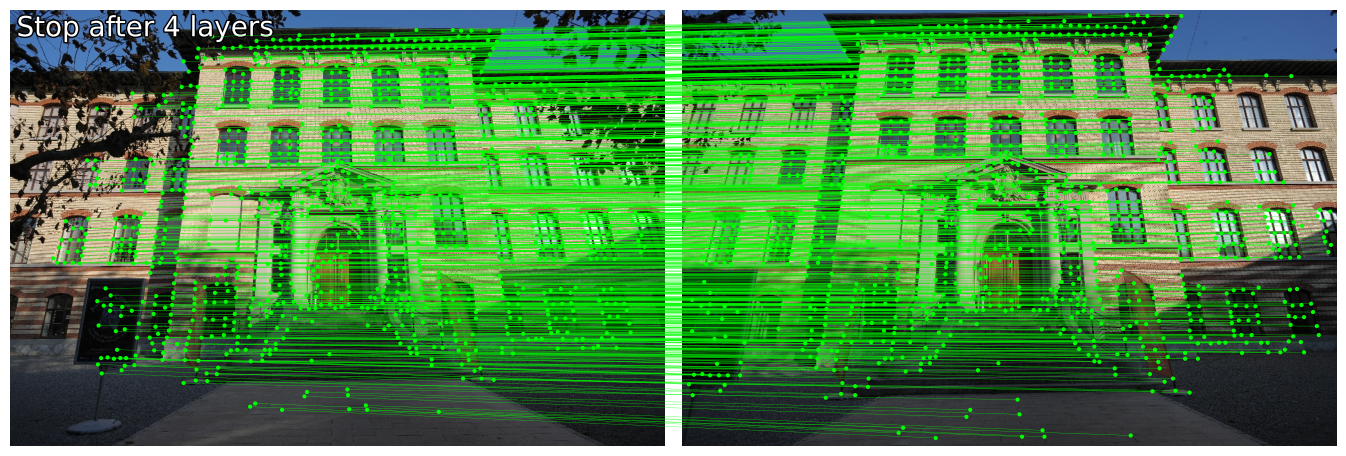

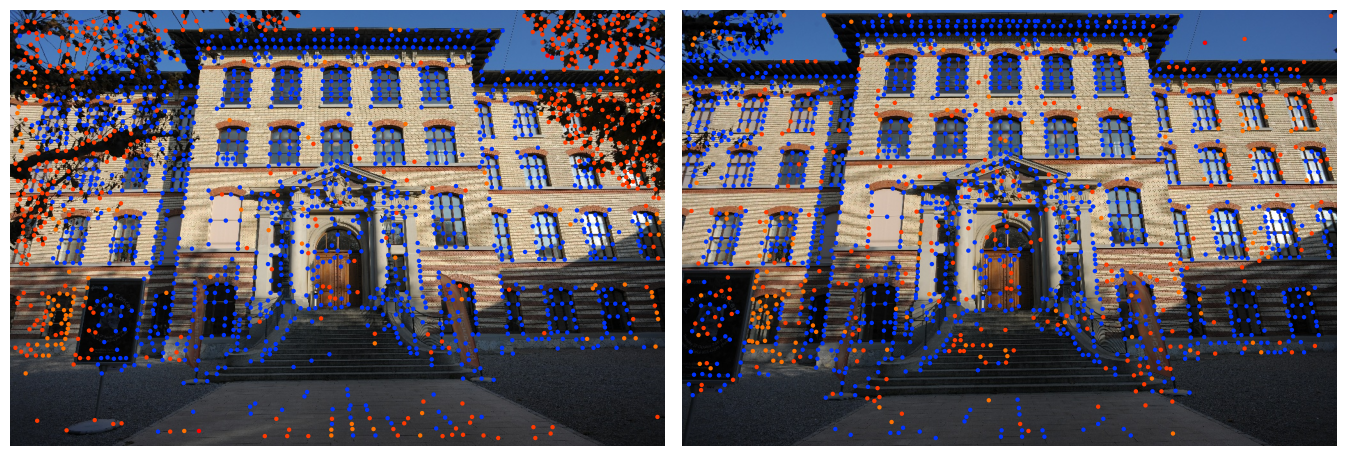

In [3]:
image0 = load_image(images / 'DSC_0411.JPG')
image1 = load_image(images / 'DSC_0410.JPG')

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({'image0': feats0, 'image1': feats1})
feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]  # remove batch dimension

kpts0, kpts1, matches = feats0['keypoints'], feats1['keypoints'], matches01['matches']
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color='lime', lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01['prune0']), viz2d.cm_prune(matches01['prune1'])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

### Open cv Image Processing

In [4]:
import cv2 
import torch
import numpy as np
import matplotlib.pyplot as plt

from lightglue import viz2d
from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import numpy_image_to_torch, rbd

In [17]:
class cfg:
    img0 = "assets/DSC_0410.JPG"
    img1 = "assets/DSC_0411.JPG"
    
    size = (512, 512)
    interpolation = cv2.INTER_AREA
    
    opencv = {
        "extractor": cv2.KAZE_create(),
        "normType": cv2.NORM_L2,
        "crossCheck": True, 
        "homography": {
            "method": cv2.RANSAC,
            "ransacReprojThreshold": 3.0
        }
    }
    lightglue = {
        "extractor": "SuperPoint", # SuperPoint, DISK
        "device": "cpu", # cpu, cuda
        "max_kpts": 2048,
        "homography": {
            "method": cv2.RANSAC,
            "ransacReprojThreshold": 3.0
        }
    }


def load_img(file, size, interpolation):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size, interpolation=interpolation)
    return img


def get_homography(src_pts, dst_pts, method, ransacReprojThreshold):
    homography, mask = cv2.findHomography(
        src_pts, 
        dst_pts, 
        method=method, 
        ransacReprojThreshold=ransacReprojThreshold
    )
    return homography, mask


def plot_two_imgs(img0, img1, title=""):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img0)
    axes[0].axis("off")
    axes[0].set_title(title)
    axes[1].imshow(img1)
    axes[1].axis("off")
    axes[1].set_title(title)
    plt.show()


    

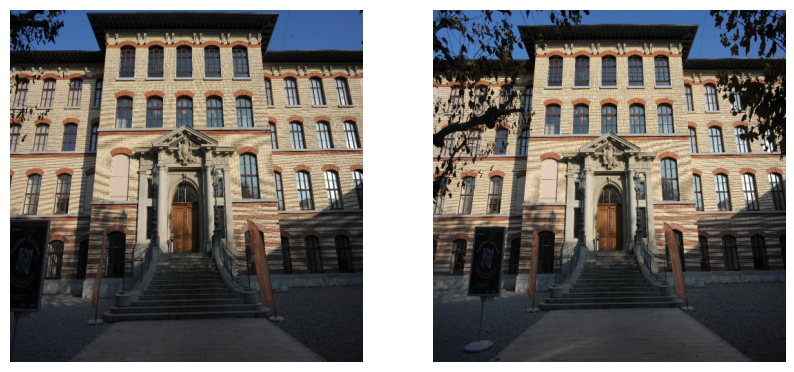

In [6]:
img0 = load_img(cfg.img0, size=cfg.size, interpolation=cfg.interpolation)
img1 = load_img(cfg.img1, size=cfg.size, interpolation=cfg.interpolation)

plot_two_imgs(img0, img1)

In [7]:

def preprocess_opencv(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img


def match_opencv(img0, img1, cfg):    
    # preprocess rgb images
    img0 = preprocess_opencv(img0)
    img1 = preprocess_opencv(img1)

    # extract local features
    extractor = cfg["extractor"]
    kp0, des0 = extractor.detectAndCompute(img0, None)
    kp1, des1 = extractor.detectAndCompute(img1, None)
    
    # match the features
    matcher = cv2.BFMatcher_create(normType=cfg["normType"], crossCheck=cfg["crossCheck"])
    matches = matcher.match(des0, des1)
    
    # extract point coordinates from keypoint objects
    src_pts = np.float32([kp0[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts = np.float32([kp1[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    
    return {
        "src_pts": src_pts,
        "dst_pts": dst_pts,
        "matches": matches,
        "kp0": kp0,
        "kp1": kp1,
        "img0": img0,
        "img1": img1
    }
    

def visualize_opencv(src_pts, dst_pts, kp0, kp1, matches, img0, img1, cfg, title="OpenCV", **kwargs):   
    homography, mask = get_homography(src_pts, dst_pts, cfg["method"], cfg["ransacReprojThreshold"])
    matches_mask = mask.ravel().tolist()
    
    # visualize mapping
    h, w = img0.shape[:2]
    pts = np.float32([[0, 0],[0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, homography)
    vis_mapping = cv2.polylines(img1.copy(), [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
    
    # visualize matches
    draw_params = dict(
        matchColor = (0, 255, 0), # draw matches in green color
        singlePointColor = None,
        matchesMask = matches_mask, # draw only inliers
        flags = 2
    )
    vis_matches = cv2.drawMatches(img0, kp0, img1, kp1, matches, None, **draw_params)
    
    # plot visualizations
    plot_two_imgs(vis_mapping, vis_matches, title=title)
    
    return homography

CPU times: user 471 ms, sys: 62.5 ms, total: 533 ms
Wall time: 197 ms


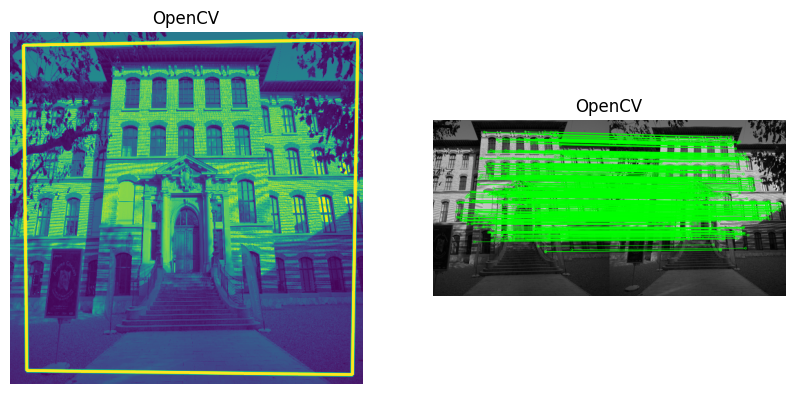

In [14]:
# OpenCV
%time results_opencv = match_opencv(img0, img1, cfg.opencv)
homography_opencv = visualize_opencv(**results_opencv, cfg=cfg.opencv["homography"], title="OpenCV")

In [15]:
def preprocess_lightglue(img):
    img = numpy_image_to_torch(img)
    return img


def match_lightglue(img0, img1, cfg):
    img0 = preprocess_lightglue(img0)
    img1 = preprocess_lightglue(img1)
    
    if cfg["extractor"] == "SuperPoint":
        extractor = SuperPoint(max_num_keypoints=cfg["max_kpts"]).eval().to(cfg["device"])
        matcher = LightGlue(features='superpoint').eval().to(cfg["device"])

    if cfg["extractor"] == "DISK":
        extractor = DISK(max_num_keypoints=cfg["max_kpts"]).eval().to(cfg["device"])  # load the extractor
        matcher = LightGlue(features='disk').eval().to(cfg["device"])  # load the matcher

    # extract local features
    feats0 = extractor.extract(img0)  # auto-resize the image, disable with resize=None
    feats1 = extractor.extract(img1)
    
    # match the features
    matches01 = matcher({'image0': feats0, 'image1': feats1})
    feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]  # remove batch dimension
    
    # get results
    kpts0 = feats0["keypoints"]
    kpts1 = feats1["keypoints"]
    matches = matches01['matches']  # indices with shape (K,2)
    points0 = kpts0[matches[..., 0]]  # coordinates in img0, shape (K,2)
    points1 = kpts1[matches[..., 1]]  # coordinates in img1, shape (K,2)
        
    return {
        "points0": points0,
        "points1": points1,
        "matches01": matches01, 
        "matches": matches,
        "kpts0": kpts0,
        "kpts1": kpts1,
        "img0": img0,
        "img1": img1
    }


def visualize_lightglue(img0, img1, points0, points1, kpts0, kpts1, matches01, **kwargs):
    axes = viz2d.plot_images([img0, img1])
    viz2d.plot_matches(points0, points1, color='lime', lw=0.2)
    viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

    kpc0, kpc1 = viz2d.cm_prune(matches01['prune0']), viz2d.cm_prune(matches01['prune1'])
    viz2d.plot_images([img0, img1])
    viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

    

CPU times: user 9.19 s, sys: 3.47 s, total: 12.7 s
Wall time: 5.87 s


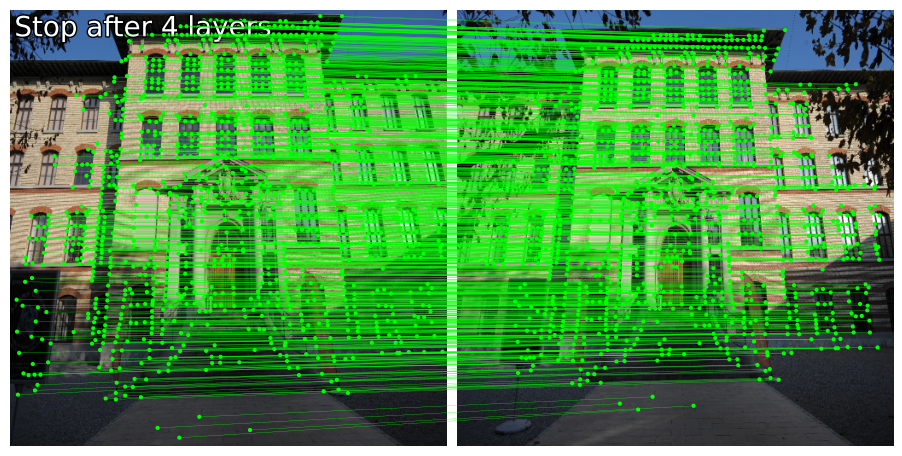

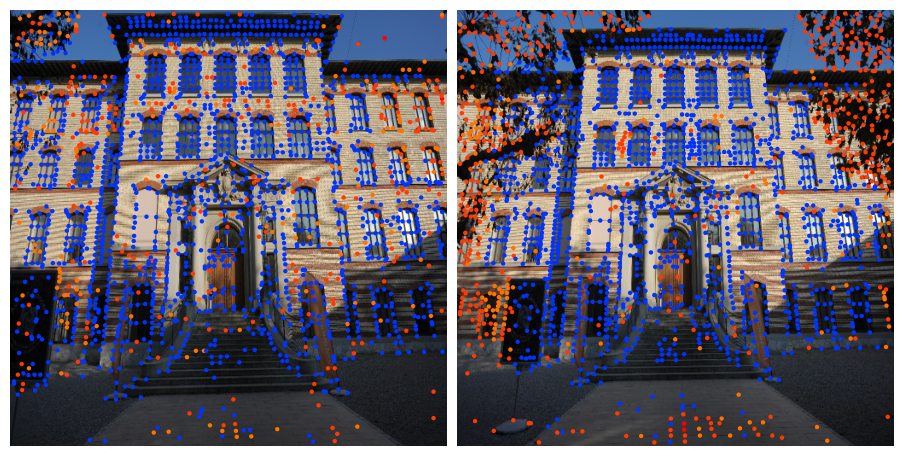

In [18]:
# LightGlue
%time results_lightglue = match_lightglue(img0, img1, cfg.lightglue)
visualize_lightglue(**results_lightglue)

CPU times: user 14.8 ms, sys: 12.7 ms, total: 27.5 ms
Wall time: 18.5 ms


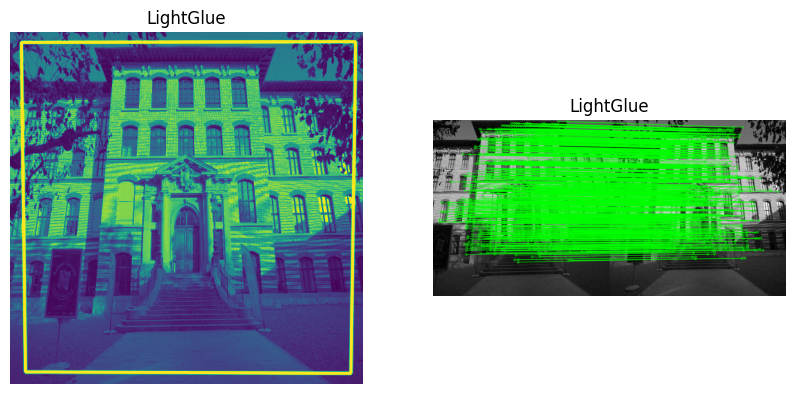

In [20]:
# Visualize LightGlue results with OpenCV tools
def lightglue2opencv(points0, points1, matches, kpts0, kpts1, img0, img1, **kwargs):
    return {
        "src_pts": points0.numpy().reshape(-1, 1, 2),
        "dst_pts": points1.numpy().reshape(-1, 1, 2),
        "kp0": cv2.KeyPoint_convert(kpts0.numpy()),
        "kp1": cv2.KeyPoint_convert(kpts1.numpy()),
        "matches": tuple(
            cv2.DMatch(matches[i][0].item(), matches[i][1].item(), 0.) 
            for i in range(matches.shape[0])
        ),
        "img0": cv2.cvtColor((255 * img0).numpy().astype(np.uint8).transpose(1, 2, 0), cv2.COLOR_RGB2GRAY),
        "img1": cv2.cvtColor((255 * img1).numpy().astype(np.uint8).transpose(1, 2, 0), cv2.COLOR_RGB2GRAY)
    }


%time results_lightglue_opencv = lightglue2opencv(**results_lightglue)
homography_lightglue = visualize_opencv(**results_lightglue_opencv, cfg=cfg.lightglue["homography"], title="LightGlue")